# 뉴스 토픽 분류하기  
- 양방향 LSTM 활용
---

## [1] 데이터 불러오기
---

In [270]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
# sklearn
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
# tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
# nlp
from konlpy.tag import Kkma, Komoran, Okt
from nltk.corpus import stopwords
import nltk as nlp

In [271]:
data = pd.read_csv('C:/Users/USER/Downloads/open/train_data.csv')
topic = pd.read_csv('C:/Users/USER/Downloads/open/topic_dict.csv')

## [2] 데이터 전처리
---

### [2-1] 결측치 확인

In [272]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45654 entries, 0 to 45653
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      45654 non-null  int64 
 1   title      45654 non-null  object
 2   topic_idx  45654 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


In [273]:
data.isna().sum()

index        0
title        0
topic_idx    0
dtype: int64

In [274]:
data.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [275]:
data = data.iloc[:,1:]
data.head()

,title,topic_idx
0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [276]:
data.topic_idx.value_counts(dropna=False)

4    7629
2    7362
5    6933
6    6751
1    6222
3    5933
0    4824
Name: topic_idx, dtype: int64

In [277]:
data.topic_idx.unique()

array([4, 6, 5, 0, 1, 3, 2], dtype=int64)

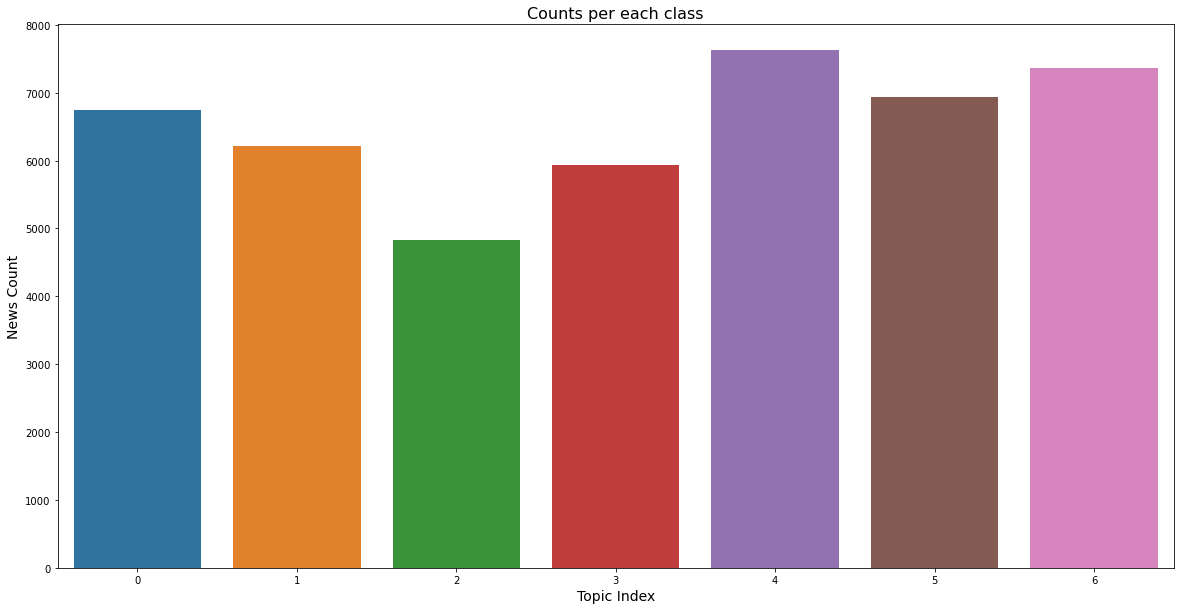

In [278]:
plt.figure(figsize = (20,10))
sns.barplot(x = data.topic_idx.unique(), y = data.topic_idx.value_counts(dropna=False))
plt.title("Counts per each class", fontdict = {"fontsize" : 16})
plt.xlabel("Topic Index", fontdict = {"fontsize" : 14})
plt.ylabel("News Count", fontdict = {"fontsize" : 14})
plt.xticks(rotation=360);

### [2-2] Preprocessing

In [279]:
data['title'][0]

'인천→핀란드 항공기 결항…휴가철 여행객 분통'

In [280]:
def makeTextlist(data):
    stopwords_01 = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    okt = Okt()
    text_list = []
    for text in tqdm(data['title']):
        text = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", " ", text) # 특수문자 제거
        text = text.strip() # 문자 처음과 끝 공백 제거
        tokens = okt.morphs(text) # 단어 추출
        text = [word for word in text if not word in stopwords_01] # 불용어 처리
        text = "".join(text)
        text = text.replace('  ',' ')
        text_list.append(text) 
    
    data["title"] = text_list 

In [281]:
makeTextlist(data)

100%|███████████████████████████████████████████████████████████████████████████| 45654/45654 [06:08<00:00, 123.82it/s]


In [282]:
data['title']

0                 인천 핀란드 항공기 결항 휴철 여행객 분통
1            실리콘밸리 넘어서겠다 구글 15조원 여 전역 거점화
2              란 외무 긴장완화 해결책 미국 경제전쟁 멈추 것
3         NYT 클린턴 측근 기업 특수관계 조명 공 사 맞물려종합
4                시진핑 트럼프 중미 무역협상 조속 타결 희망
                       ...               
45649         KB금융 미국 IB 스티펠 제휴 선진국 시장 공략
45650      1보 서울시교육청 신종코로나 확산 개학 연기 휴업 검토
45651          게시판 키움증권 2020 키움 영웅전 실전투대회
45652                    답변하 배기동 국립중앙박물관장
45653    2020 국인터넷기상 시상식 내달 1일 개최 특별상 김성후
Name: title, Length: 45654, dtype: object

In [283]:
# 단어 개수 column 추가
data['word_counts'] = [len(i.split(' ')) for i in data["title"]]
data['word_counts'].max()

14

In [284]:
sent_length = data['word_counts'].max()

In [285]:
# Under Sampling
minCounts = data['topic_idx'].value_counts(dropna=False).min()

data0 = data[data["topic_idx"] == 0]
data1 = data[data["topic_idx"]== 1][:minCounts]
data2 = data[data["topic_idx"]== 2][:minCounts]
data3 = data[data["topic_idx"]== 3][:minCounts]
data4 = data[data["topic_idx"]== 4][:minCounts]
data5 = data[data["topic_idx"]== 5][:minCounts]
data6 = data[data["topic_idx"]== 6][:minCounts]
data = pd.concat([data0, data1, data2, data3, data4, data5, data6], axis = 0)
data.head()

,title,topic_idx,word_counts
617,지카바러스 규명 초저온전현미경 신약연구 유용,0,5
622,증강현실 알파고 어 포켓몬 고 거센 IT 광풍,0,9
643,AI 월드컵 생생 현장 중계,0,5
654,세돌 알파고 집중력 사람 기긴 어렵다 일문일답종합2보,0,7
660,올해 휴대폰 국내 생산량 2천500만대 10년전 18 4,0,8


In [286]:
data.tail()

,title,topic_idx,word_counts
29361,총선 D8 신공항공세 차단 더민주 서부산 공략 강화,6,9
29366,더민주 제주 경선 끝날 때까지 위원장 직무대행 체제,6,8
29376,비대위 첫날 쓴소리 봇물 국민 뜻대로 다 바꾸겠습니다,6,8
29379,문대통령 국정지지 45 로 1 p 상승 부정평 44 국갤럽,6,10
29404,나경원 관훈클럽 초청 토론회 참석,6,5


In [287]:
data = data.reset_index(drop=True)
data.head()

,title,topic_idx,word_counts
0,지카바러스 규명 초저온전현미경 신약연구 유용,0,5
1,증강현실 알파고 어 포켓몬 고 거센 IT 광풍,0,9
2,AI 월드컵 생생 현장 중계,0,5
3,세돌 알파고 집중력 사람 기긴 어렵다 일문일답종합2보,0,7
4,올해 휴대폰 국내 생산량 2천500만대 10년전 18 4,0,8


In [288]:
finalData = data['title']
finalData.head()

0           지카바러스 규명 초저온전현미경 신약연구 유용
1         증강현실  알파고 어 포켓몬 고 거센 IT 광풍
2                    AI 월드컵 생생 현장 중계
3      세돌 알파고 집중력 사람 기긴 어렵다 일문일답종합2보
4    올해 휴대폰 국내 생산량 2천500만대 10년전 18 4
Name: title, dtype: object

In [289]:
# target data 생성
target = data['topic_idx']

In [290]:
target.value_counts()

0    4824
1    4824
2    4824
3    4824
4    4824
5    4824
6    4824
Name: topic_idx, dtype: int64

In [291]:
finalData.shape, target.shape

((33768,), (33768,))

### [2-3] Tokenization

In [292]:
corpus = []
for i in finalData:
    corpus.append(i)

In [293]:
tokenizer = Tokenizer(num_words=10000)  
tokenizer.fit_on_texts(corpus)

In [294]:
len(tokenizer.word_counts)

56588

In [295]:
# 희귀 단어 빈도수 
def checkToken(tokenizer, threshold) :
    
    
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value
    

    total = (rare_freq / total_freq)*100

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 미만인 희귀 단어의 수: %s'%(threshold, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    return total_cnt-rare_cnt

In [296]:
checkToken(tokenizer, 4)

단어 집합(vocabulary)의 크기 : 56588
등장 빈도가 4번 미만인 희귀 단어의 수: 46517
단어 집합에서 희귀 단어의 비율: 82.20294055276737
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 25.87778457310892


10071

### [2-4] Token Embedding

In [297]:
# 정수 인코딩
encoded_docs = tokenizer.texts_to_sequences(corpus)
encoded_docs[0]

[6655, 1124, 3958]

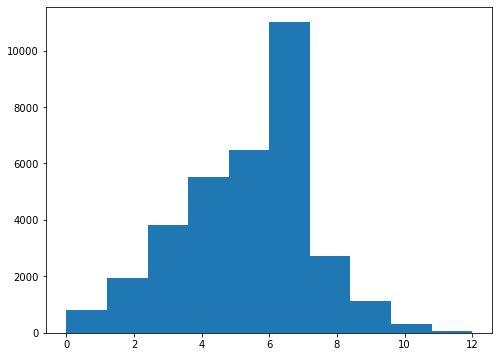

최대 길이 12


In [298]:
list_len = []

for i in range(0, len(encoded_docs)) :
    list_len.append(len(encoded_docs[i]))

plt.figure(figsize = (8, 6))
plt.hist(list_len)
plt.show()

print("최대 길이", max(list_len))

In [299]:
# 패딩
embedded_docs=pad_sequences(encoded_docs,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 6655 1124 3958]
 [   0    0    0 ...  474 3066 1341]
 [   0    0    0 ... 5656  628 1976]
 ...
 [   0    0    0 ... 2680  187  402]
 [   0    0    0 ... 1537  119 3468]
 [   0    0    0 ...  712  851  259]]


## [3] 모델 생성
---

In [300]:
# 양방향 LSTM
def create_model():

    model1=Sequential()
    model1.add(Embedding(10000,64,input_length=sent_length))
    model1.add(Bidirectional(LSTM(50)))
    model1.add(Dropout(0.3))
    model1.add(Dense(7,activation='softmax'))
    model1.compile(loss='CategoricalCrossentropy',optimizer='adam',metrics=['accuracy'])
    print(model1.summary())
    return model1

In [301]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [302]:
results

array([0.72842932, 0.74733919, 0.73276263, 0.7528922 , 0.7339195 ])

In [303]:
len(embedded_docs),target.shape

(33768, (33768,))

In [304]:
# numpy 배열로 변경
X_final=np.array(embedded_docs)
y_final=np.array(target)

In [305]:
# ont-hot 인코딩
y_final = np_utils.to_categorical(y_final)

In [306]:
X_final.shape, y_final.shape

((33768, 14), (33768, 7))

### train, test, val 데이터 분리

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [308]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [309]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(21611, 14)
(21611, 7)
(6754, 14)
(6754, 7)
(5403, 14)
(5403, 7)


## [4] 모델 훈련
---

In [310]:
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)
cp = ModelCheckpoint("./bidirectional_model.h5" ,save_best_only = True)

In [311]:
hist = create_model().fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,callbacks=[es,cp],batch_size=100)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 14, 64)            640000    
                                                                 
 bidirectional_12 (Bidirecti  (None, 100)              46000     
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 7)                 707       
                                                                 
Total params: 686,707
Trainable params: 686,707
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
217/217 [==============================] - 25s 58ms/step - loss: 1.3442 - accuracy: 0.5027 - val_

Text(0, 0.5, 'Loss')

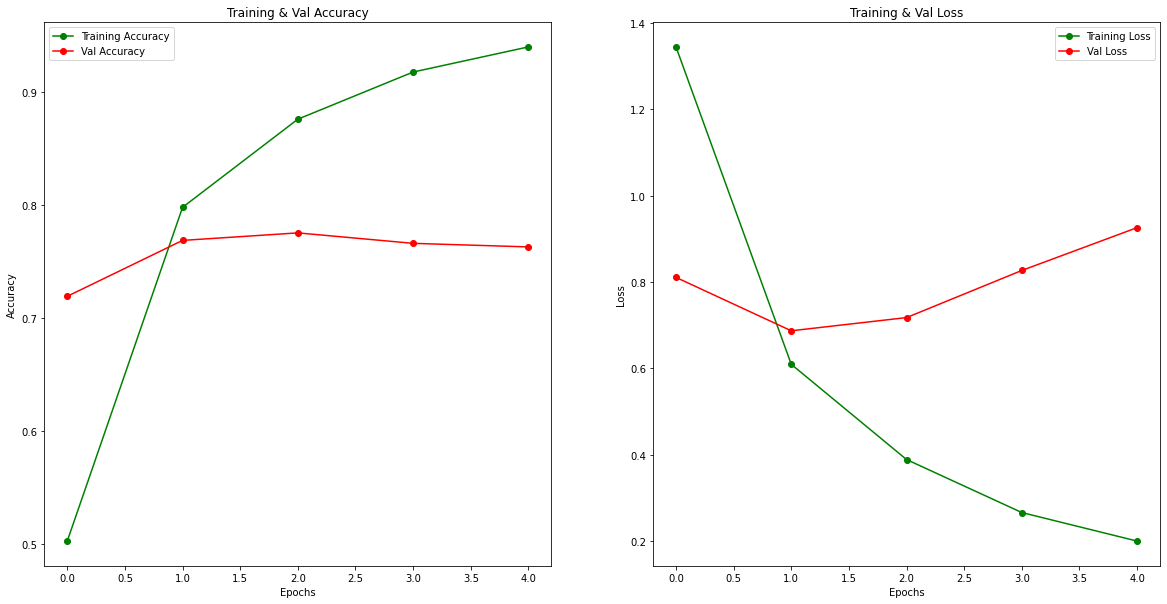

In [312]:
epochs = [i for i in hist.epoch]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Val Accuracy')
ax[0].set_title('Training & Val Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Val Loss')
ax[1].set_title('Training & Val Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

## [5] 모델 예측
---

In [313]:
y_pred1=model1.predict(X_test)

212/212 [==============================] - 1s 5ms/step


In [314]:
y_pred1 = np.argmax(y_pred1, axis=1)

In [315]:
y_pred1

array([5, 3, 5, ..., 0, 2, 5], dtype=int64)

In [316]:
y_test = np.argmax(y_test, axis=1)

In [317]:
y_test

array([5, 3, 5, ..., 0, 1, 5], dtype=int64)

In [318]:
confusion_matrix(y_test,y_pred1)

array([[776,  77,  41,  35,  13,   9,   4],
       [113, 684, 111,  38,  24,   7,   5],
       [ 77,  97, 498, 145,  63,  15,  77],
       [ 32,  14,  39, 828,  11,  12,   5],
       [ 21,  22,  50,  43, 739,  27,  55],
       [ 13,   5,  12,  27,  31, 890,   3],
       [  8,   4,  79,  41,  76,   5, 753]], dtype=int64)

In [319]:
accuracy_score(y_test,y_pred1)

0.7651761918862896

In [320]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       955
           1       0.76      0.70      0.73       982
           2       0.60      0.51      0.55       972
           3       0.72      0.88      0.79       941
           4       0.77      0.77      0.77       957
           5       0.92      0.91      0.91       981
           6       0.83      0.78      0.81       966

    accuracy                           0.77      6754
   macro avg       0.76      0.77      0.76      6754
weighted avg       0.76      0.77      0.76      6754

